In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.io as spio
import matplotlib.pyplot as plt
import os
import glob

In [2]:
eeg_dir = 'eeg_data_anon'

In [3]:
subject_data_dir = glob.glob(os.path.join(eeg_dir, 'p*'))
print(subject_data_dir)

['eeg_data_anon/p6', 'eeg_data_anon/p7', 'eeg_data_anon/p13', 'eeg_data_anon/p22', 'eeg_data_anon/p17', 'eeg_data_anon/p15', 'eeg_data_anon/p23', 'eeg_data_anon/p5', 'eeg_data_anon/p10', 'eeg_data_anon/p9', 'eeg_data_anon/p20', 'eeg_data_anon/p2', 'eeg_data_anon/p19', 'eeg_data_anon/p4', 'eeg_data_anon/p8', 'eeg_data_anon/p12']


In [4]:
subject_data = [glob.glob(os.path.join(x, '*')) for x in subject_data_dir]

In [5]:
all_eeg_data = [x[21] for x in subject_data]
all_joystick_data = [x[15] for x in subject_data]

In [6]:
print(all_eeg_data)
print('')
print(all_joystick_data)

['eeg_data_anon/p6/eeg.mat', 'eeg_data_anon/p7/eeg.mat', 'eeg_data_anon/p13/eeg.mat', 'eeg_data_anon/p22/eeg.mat', 'eeg_data_anon/p17/eeg.mat', 'eeg_data_anon/p15/eeg.mat', 'eeg_data_anon/p23/eeg.mat', 'eeg_data_anon/p5/eeg.mat', 'eeg_data_anon/p10/eeg.mat', 'eeg_data_anon/p9/eeg.mat', 'eeg_data_anon/p20/eeg.mat', 'eeg_data_anon/p2/eeg.mat', 'eeg_data_anon/p19/eeg.mat', 'eeg_data_anon/p4/eeg.mat', 'eeg_data_anon/p8/eeg.mat', 'eeg_data_anon/p12/eeg.mat']

['eeg_data_anon/p6/joystick.mat', 'eeg_data_anon/p7/joystick.mat', 'eeg_data_anon/p13/joystick.mat', 'eeg_data_anon/p22/joystick.mat', 'eeg_data_anon/p17/joystick.mat', 'eeg_data_anon/p15/joystick.mat', 'eeg_data_anon/p23/joystick.mat', 'eeg_data_anon/p5/joystick.mat', 'eeg_data_anon/p10/joystick.mat', 'eeg_data_anon/p9/joystick.mat', 'eeg_data_anon/p20/joystick.mat', 'eeg_data_anon/p2/joystick.mat', 'eeg_data_anon/p19/joystick.mat', 'eeg_data_anon/p4/joystick.mat', 'eeg_data_anon/p8/joystick.mat', 'eeg_data_anon/p12/joystick.mat']


In [16]:
def normalize_and_crop(eeg:np.array, ft:np.array) -> tuple:
    '''
    Take the EEG data and the corresponding joystick feel trace, and normalize both to be [0,1]
    and crop the eeg, and feel trace to be in the same time period
    '''
    min_index = np.where(ft[:,0] >= 0)[0][0]# first positive time stamp
    max_index = int(min(eeg[:,0][-2], ft[:,0][-1]))
    # find the index on ft that is greater than or equal to the max index timestamp
    ft_end_index = np.where(ft[:,0] > max_index)[0][0] - 1 if ft[:,0][-1] > eeg[:,0][-2] else np.where(ft[:,0] == max_index)[0][0]
    
    new_ft = ft[min_index:ft_end_index+1, :].copy()
    new_eeg = eeg[int(ft[:,0][min_index]):max_index+1,:-1].copy()
    
    # normalize to be between [0,1]
    min_eeg = np.min(new_eeg[:,1:], axis=0)
    max_eeg = np.max(new_eeg[:,1:], axis=0)
    
    min_ft = np.min(ft[:,1])
    max_ft = np.max(ft[:,1])
    
    new_eeg[:,1:] = (new_eeg[:,1:] - min_eeg)/(max_eeg - min_eeg)
    new_ft[:,1] = (new_ft[:,1]-min_ft)/(max_ft-min_ft)
    
    new_ft[:,0] = new_ft[:,0]/1000 # ms to seconds
    new_eeg[:,0] = new_eeg[:,0]/1000 # ms to seconds
    
    return (new_eeg, new_ft)

In [17]:
# this step takes a lot of memory!!

eeg_column_headers = ['t'] + [f'channel_{i}' for i in range(64)]
ft_column_headers = ['t', 'stress']

del eeg_data
del ft_data

eeg_ft_pairs = [(eeg,ft) for eeg,ft in zip(all_eeg_data,all_joystick_data)]

eeg_data = np.array([])
ft_data = np.array([])
for index, (x,y) in enumerate(eeg_ft_pairs):
    eeg, ft = spio.loadmat(x)['var'], spio.loadmat(y)['var']
    normalized_eeg, normalized_ft = normalize_and_crop(eeg,ft)
    
    eeg_csv_data = {col_name : col_data for (col_name, col_data) in zip(eeg_column_headers, normalized_eeg)}
    ft_csv_data = {col_name : col_data for (col_name, col_data) in zip(ft_column_headers, normalized_ft)}
    
    eeg_df = pd.DataFrame(data=eeg_csv_data)
    ft_df = pd.DataFrame(data=ft_csv_data)
    
    eeg_df.to_csv(os.path.join(data, f'normalized_eeg_{index}.csv'), index=False)
    ft_df.to_csv(os.path.join(data, f'normalized_ft_{index}.csv'), index=False)

In [199]:
print(eeg_ft_pairs)

[('eeg_data_anon/p6/eeg.mat', 'eeg_data_anon/p6/joystick.mat'), ('eeg_data_anon/p7/eeg.mat', 'eeg_data_anon/p7/joystick.mat'), ('eeg_data_anon/p13/eeg.mat', 'eeg_data_anon/p13/joystick.mat'), ('eeg_data_anon/p22/eeg.mat', 'eeg_data_anon/p22/joystick.mat'), ('eeg_data_anon/p17/eeg.mat', 'eeg_data_anon/p17/joystick.mat'), ('eeg_data_anon/p15/eeg.mat', 'eeg_data_anon/p15/joystick.mat'), ('eeg_data_anon/p23/eeg.mat', 'eeg_data_anon/p23/joystick.mat'), ('eeg_data_anon/p5/eeg.mat', 'eeg_data_anon/p5/joystick.mat'), ('eeg_data_anon/p10/eeg.mat', 'eeg_data_anon/p10/joystick.mat'), ('eeg_data_anon/p9/eeg.mat', 'eeg_data_anon/p9/joystick.mat'), ('eeg_data_anon/p20/eeg.mat', 'eeg_data_anon/p20/joystick.mat'), ('eeg_data_anon/p2/eeg.mat', 'eeg_data_anon/p2/joystick.mat'), ('eeg_data_anon/p19/eeg.mat', 'eeg_data_anon/p19/joystick.mat'), ('eeg_data_anon/p4/eeg.mat', 'eeg_data_anon/p4/joystick.mat'), ('eeg_data_anon/p8/eeg.mat', 'eeg_data_anon/p8/joystick.mat'), ('eeg_data_anon/p12/eeg.mat', 'eeg_dat

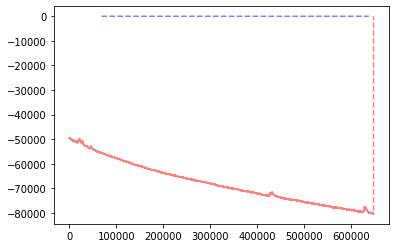

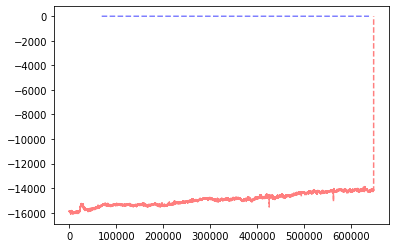

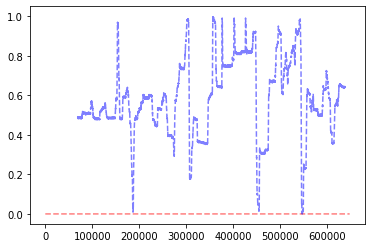

In [181]:
for i in range(63,66):
    min_eeg = 0#np.min(eeg_mat0['var'][:,i])
    max_eeg = 1#np.max(eeg_mat0['var'][:,i])
    
    min_joystick = np.min(joystick_mat0['var'][:,1])
    max_joystick = np.max(joystick_mat0['var'][:,1])
    
    plt.plot(eeg_mat0['var'][:,0], (eeg_mat0['var'][:,i] - min_eeg)/(max_eeg-min_eeg), 'r--', alpha=0.5)
    plt.plot(joystick_mat0['var'][:,0], (joystick_mat0['var'][:,1] - min_joystick)/(max_joystick - min_joystick), 'b--', alpha=0.5)
    plt.show()

In [101]:
eeg_mat0['var'][:,0][-1]

948738.0

In [94]:
joystick_mat0['var'][:,0].shape

(26914,)